In [1]:
import torch 
device = torch.device('cuda:7')

In [2]:
import wget
import os

print('Downloading dataset...')

url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [3]:
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

In [4]:
import pandas as pd

df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
val_df = pd.read_csv("./cola_public/raw/in_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

print(f'Number of training sentences: {df.shape[0]}')
print(f'Number of Validating Sentences : {val_df.shape[0]}')
df.sample(10)

Number of training sentences: 8551
Number of Validating Sentences : 527


,sentence_source,label,label_notes,sentence
3661,ks08,1,NaN,John seems certain about the bananas.
3086,l-93,1,NaN,Ellen complained about the situation.
6452,d_98,0,*,Mary didn't see almost every flower.
3681,ks08,1,NaN,John suddenly put off the customers.
5499,b_73,1,NaN,So elegant a solution as you have presented us...
5411,b_73,1,NaN,I have much typing to do.
8019,ad03,1,NaN,Jason expected Medea to be treated by the doctor
4142,ks08,0,*,The characters in Shakespeare's Twelfth Night ...
483,bc01,1,NaN,There promises to be a storm tonight.
6167,c_13,1,NaN,Whom did Matt kiss?


In [5]:
sentences = df.sentence.values
val_sentences = val_df.sentence.values
lables = df.label.values
val_lables = val_df.label.values

lables = list(lables) + list(val_lables)
print(f'Number of samples : {len(lables)}')

Number of samples : 9078


In [6]:
from transformers import BertTokenizer

print('Loading BERT Tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT Tokenizer...


In [7]:

print(' Original: ', sentences[0])
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


In [8]:
max_len = 0

for sentence in sentences:

    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  47


In [9]:

input_ids = []
attention_masks = []

for sentence in sentences:
    encoded_dict = tokenizer.encode_plus(sentence,add_special_tokens = True, max_length = 64,pad_to_max_length = True,return_attention_mask = True, return_tensors = 'pt',)
       
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

for sentence in val_sentences:
    encoded_dict = tokenizer.encode_plus(sentence,add_special_tokens = True, max_length = 64,pad_to_max_length = True,return_attention_mask = True, return_tensors = 'pt',)
       
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(lables)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[8550])
print('Token IDs:', input_ids[8550])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/data5/home/bhargavav2/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  What all did you get for Christmas?
Token IDs: tensor([ 101, 2054, 2035, 2106, 2017, 2131, 2005, 4234, 1029,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


In [10]:
#Spliting Data

from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f'{train_size} training samples')
print(f'{val_size} validation samples')

8170 training samples
908 validation samples


In [11]:
#DaatLoaders
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(train_dataset,  sampler = RandomSampler(train_dataset),batch_size = batch_size )
validation_dataloader = DataLoader(val_dataset,  sampler = RandomSampler(val_dataset),batch_size = batch_size )

In [12]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",  num_labels = 2,output_attentions = False, output_hidden_states = False, )

model.cuda(device)

2023-09-14 14:38:58.485144: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 14:38:59.140712: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [13]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [14]:
optimizer = AdamW(model.parameters(),lr = 5e-5, eps = 1e-8 )

/data5/home/bhargavav2/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
from transformers import get_linear_schedule_with_warmup


epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [16]:
import numpy as np

def find_accuracy(pred , label):
    pred_flat = np.argmax(pred , axis=1).flatten()
    label_flat = label.flatten()
    return np.sum(pred_flat == label_flat) / len(label_flat)

In [17]:
import random

def setSeed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

setSeed(42)

In [18]:
#Training
from tqdm import tqdm
training_stats = []


# For each epoch...
for epoch in range(0, epochs):
    total_train_loss = 0
    total_train_acc =0
    model.train()
    for step, batch in tqdm(enumerate(train_dataloader)):

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        
        output = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = output.loss
        logits = output.logits
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_train_acc += find_accuracy(logits, label_ids)

    avg_train_loss = total_train_loss / len(train_dataloader) 
    avg_train_acc = total_train_acc / len(train_dataloader)       

    print(f'Epoch[{epoch+1}]  Train Loss : {round(avg_train_loss,10)}  Train Accuracy : {round(avg_train_acc,10)}')    

    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in tqdm(validation_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():        
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)
        loss = result.loss
        logits = result.logits
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()


        total_eval_accuracy += find_accuracy(logits, label_ids)
        

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    print(f'Validation Loss : {round(avg_val_loss,10)}  Validation Accuracy : {round(avg_val_accuracy,10)}')

    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Training Accuracy' : avg_train_acc,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,

        }
    )

print("Training complete!")

256it [00:24, 10.36it/s]


Epoch[1]  Train Loss : 0.4881108627  Train Accuracy : 0.7670166016


100%|██████████| 29/29 [00:00<00:00, 37.57it/s]


Validation Loss : 0.3730077322  Validation Accuracy : 0.8344109195


256it [00:23, 10.76it/s]


Epoch[2]  Train Loss : 0.2509726374  Train Accuracy : 0.9062255859


100%|██████████| 29/29 [00:01<00:00, 28.35it/s]


Validation Loss : 0.4197355236  Validation Accuracy : 0.8451867816


256it [00:24, 10.48it/s]


Epoch[3]  Train Loss : 0.1243073453  Train Accuracy : 0.9583740234


100%|██████████| 29/29 [00:00<00:00, 37.56it/s]


Validation Loss : 0.4801585127  Validation Accuracy : 0.8559626437


256it [00:23, 10.69it/s]


Epoch[4]  Train Loss : 0.0685249749  Train Accuracy : 0.9794921875


100%|██████████| 29/29 [00:00<00:00, 29.40it/s]

Validation Loss : 0.6876037614  Validation Accuracy : 0.8530890805
Training complete!


In [19]:
#Status
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Training Accuracy,Valid. Loss,Valid. Accur.
epoch,,,,
1,0.488111,0.767017,0.373008,0.834411
2,0.250973,0.906226,0.419736,0.845187
3,0.124307,0.958374,0.480159,0.855963
4,0.068525,0.979492,0.687604,0.853089


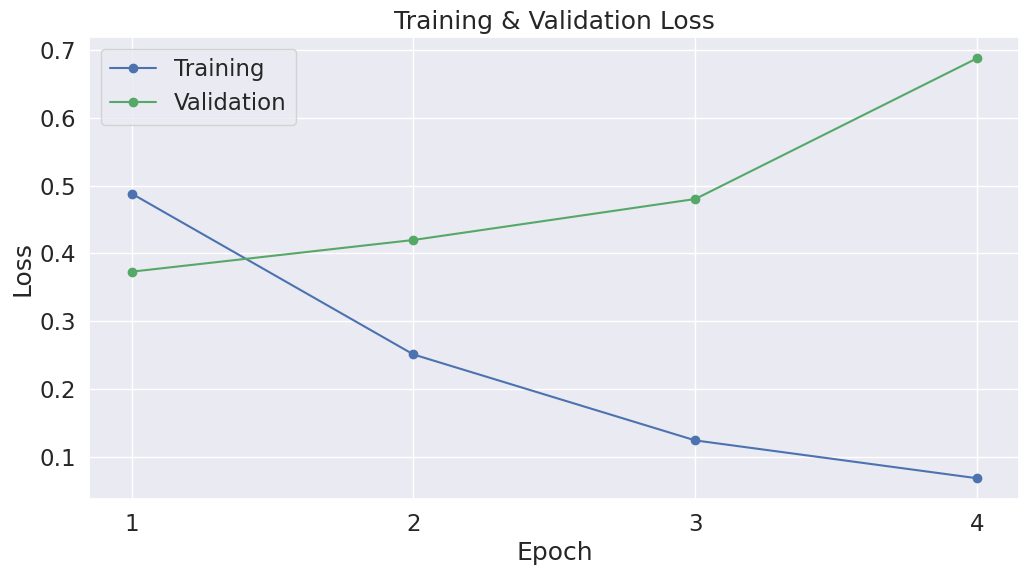

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')


sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")


plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [21]:
#Testing 

df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

print(f'Number of test sentences: {df.shape[0]}')

sentences = df.sentence.values
labels = df.label.values

input_ids = []
attention_masks = []

# For every sentence...
for sentence in sentences:

    encoded_dict = tokenizer.encode_plus(sentence,add_special_tokens = True, max_length = 64,pad_to_max_length = True,return_attention_mask = True, return_tensors = 'pt',)
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516


/data5/home/bhargavav2/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [22]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [23]:
#Prediciting


model.eval()

predicitions , true_lables = [] , []

for batch in tqdm(prediction_dataloader):
    batch = tuple(t.to(device) for t in batch)
    input_ids , input_mask , input_lables = batch

    with torch.no_grad():
        
        output = model(input_ids , token_type_ids=None,attention_mask=input_mask,return_dict=True)
    
    logits = output.logits

    logits = logits.detach().cpu().numpy()
    labels = input_lables.to('cpu').numpy()

    predicitions.append(logits)
    true_lables.append(labels)

print('Done')


100%|██████████| 17/17 [00:00<00:00, 20.08it/s]

Done


In [27]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

print('Calculating Matthews Corr. Coef. for each batch...')

for i in range(len(true_lables)):
  pred_labels_i = np.argmax(predicitions[i], axis=1).flatten() 
  matthews = matthews_corrcoef(true_lables[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


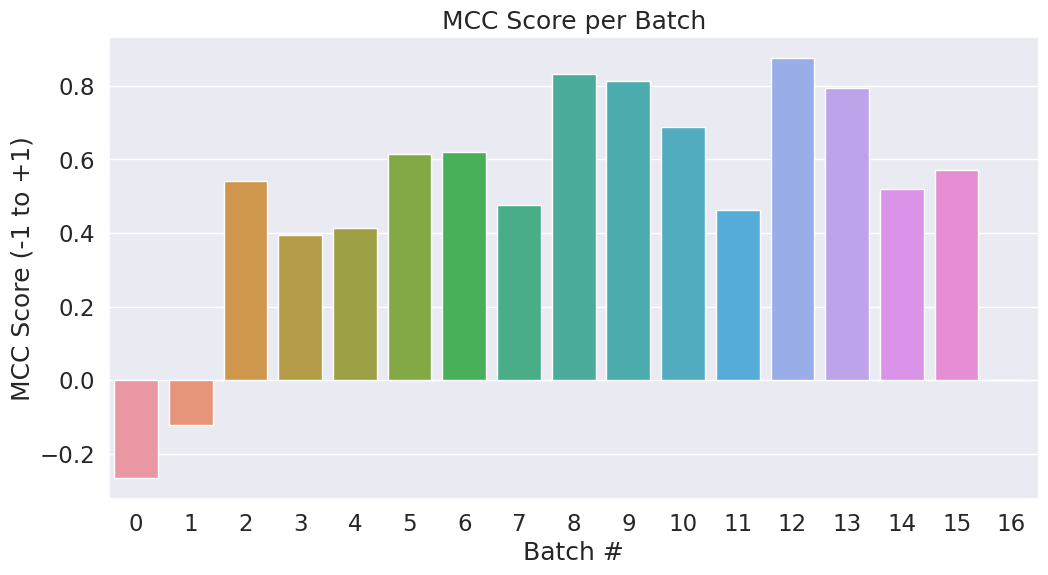

In [28]:
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [30]:
flat_predictions = np.concatenate(predicitions, axis=0)


flat_predictions = np.argmax(flat_predictions, axis=1).flatten()


flat_true_labels = np.concatenate(true_lables, axis=0)


mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.530


In [31]:
#Saving Model
output_dir = './model_save/'


if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')